In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Hide Numpy warnings from Statsmodels
import warnings
warnings.filterwarnings('ignore')

# Load data

One of the most recognisable datasets is the `auto` dataset.

Stata has examples of [influence analysis](https://www.stata.com/features/overview/linear-regression-and-influence/) on a model fitted to that dataset.

Let's do similar analysis with Appelpy, but first a bit of data pre-processing is needed.

In [2]:
from appelpy.utils import InteractionEncoder

In [3]:
df = pd.read_stata('data/auto.dta')

In [4]:
df['foreign'] = np.where(df['foreign'] == 'Domestic', 0, 1)

In [5]:
%%time
df = InteractionEncoder(df, {'foreign': ['mpg']}).transform()

Wall time: 7.99 ms


In [6]:
df.head()

,make,price,mpg,rep78,headroom,trunk,weight,length,turn,displacement,gear_ratio,foreign,foreign#mpg
0,AMC Concord,4099,22,3.0,2.5,11,2930,186,40,121,3.58,0,0
1,AMC Pacer,4749,17,3.0,3.0,11,3350,173,40,258,2.53,0,0
2,AMC Spirit,3799,22,NaN,3.0,12,2640,168,35,121,3.08,0,0
3,Buick Century,4816,20,3.0,4.5,16,3250,196,40,196,2.93,0,0
4,Buick Electra,7827,15,4.0,4.0,20,4080,222,43,350,2.41,0,0


In [7]:
df.shape

(74, 13)

# Fit model

In [8]:
from appelpy.linear_model import OLS

Specify the dependant and independent variables to include in the model.

In [9]:
y_list = ['price']
X_list = ['weight', 'foreign', 'mpg', 'foreign#mpg']

In [10]:
%%time
model = OLS(df, y_list, X_list).fit()

Wall time: 410 ms


In [11]:
model.results_output

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     21.22
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.92e-11
Time:                        19:58:09   Log-Likelihood:                -666.03
No. Observations:                  74   AIC:                             1342.
Df Residuals:                      69   BIC:                             1354.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.445e+04   4425.720     -3.265      0.002   -2.33e+04   -5620.510
weight          4.6136      0.725      6.359      0.000       3.166       6.061
foreign      1.124e+04   2751.681      4.085      0.000    5750.878    1.67e+04
mpg           263.1875    110.796      2.375      0.020      42.155     484.220
foreign#mpg  -307.2166    108.531     -2.831      0.006    -523.729     -90.704
==============================================================================
Omnibus:                       26.290   Durbin-Watson:                   1.349
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.918
Skew:                           1.355   Prob(JB):                     2.91e-10
Kurtosis:                       5.626   Cond. No.                     6.52e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
model.model_selection_stats

{'Root MSE': 2031.440307552497,
 'R-squared': 0.5516277022236807,
 'R-squared (adj)': 0.5256351052511405,
 'AIC': 1342.0680164284709,
 'BIC': 1353.5883418944918}

# Influence, leverage and outliers

In [13]:
from appelpy.diagnostics import BadApples

Instantiate a **`BadApples` object** with an Appelpy model object.

All the calculations of influence, leverage and outliers are done when the object is instantiated.

The calculations are mostly done in Statsmodels but there is a more intuitive decomposition of the measures in Appelpy.  For example, the residual measures are recognised as measures of `outliers`, which is more specific than 'influence'.

In [14]:
%%time
bad_apples = BadApples(model).fit()

Wall time: 78.1 ms


With the object set up, call the **`plot_leverage_vs_residuals_squared` method** to do a plot of leverage values against normalized residuals squared.

There are two **keyword arguments:**
- `rescale`: if True, this has the x-axis as normalized residuals squared divided by the number of observations.  Set this to True to have the same x-axis as Stata's `lvr2plot`.
- `annotate`: if True, then show annotations for observations that have a higher-than-average leverage or a higher-than-average normalized residuals squared.

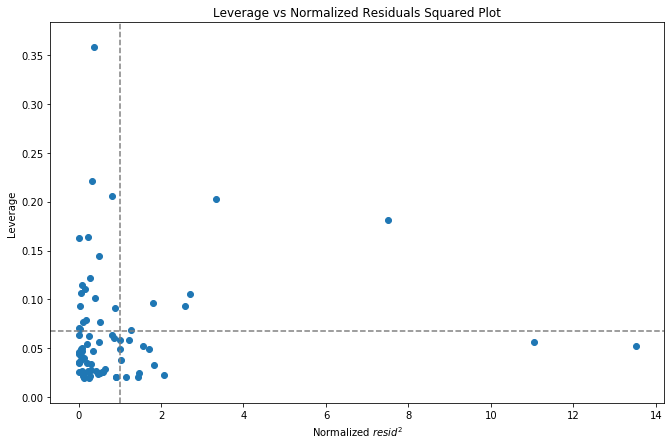

Wall time: 1.3 s


In [15]:
%%time
fig, ax = plt.subplots(figsize=(11,7))
bad_apples.plot_leverage_vs_residuals_squared()
plt.show()

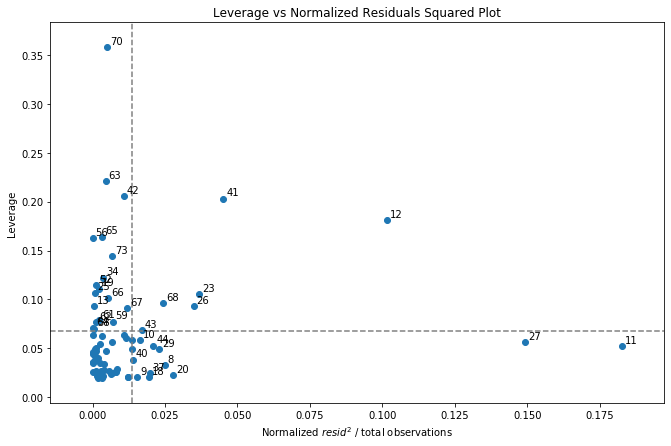

Wall time: 536 ms


In [16]:
%%time
fig, ax = plt.subplots(figsize=(11,7))
bad_apples.plot_leverage_vs_residuals_squared(rescale=True, annotate=True)
plt.show()

Outlier points have the highest values along the x-axis in the plot.

In [17]:
bad_apples.indices_outliers

[11, 12, 27]

High leverage points have the highest values along the y-axis in the plot.

In [18]:
bad_apples.indices_high_leverage

[12, 41, 42, 56, 63, 65, 70, 73]

The upper-right quadrant of the plot has high-influence points.

In [19]:
bad_apples.indices_high_influence

[11, 12, 23, 26, 27, 41, 42, 63, 68]

The `indices` attributes are calculated based on common heuristics of what are extreme values by each measure.

See the heuristics below (where `n` is number of observations and `k` is number of regressors).

|Measure|Measure type|<div style="width:150px">Heuristic</div>|
| ----- | ----- | ----- |
|dfbeta|Influence|$v > 2 / \sqrt{n}$|
|dffits|Influence|$v > 2 * \sqrt{k/n}$|
|cooks_d|Influence|$v > 4 / n$|
|leverage|Leverage|$v > (2k + 2)/n$|
|resid_standard|Outlier|$|v| > 2$|
|resid_student|Outlier|$|v| > 2$|

Let's examine the observations with the most extreme DFBETA values for the `foreign` column in more detail, via another dataframe called `df_influence`.

In [20]:
df_influence = pd.merge(df[['make'] + X_list + y_list],
                        bad_apples.measures_influence['dfbeta_foreign'],
                        how='left', left_index=True, right_index=True)

Show observations with the most negative influence on the `foreign` coefficient.

In [21]:
df_influence.sort_values('dfbeta_foreign').head()

,make,weight,foreign,mpg,foreign#mpg,price,dfbeta_foreign
41,Plym. Arrow,3260,0,28,0,4647,-0.662242
11,Cad. Eldorado,3900,0,14,0,14500,-0.529052
27,Linc. Versailles,3830,0,14,0,13466,-0.528373
68,Toyota Corona,2670,1,18,18,5719,-0.256431
70,VW Diesel,2040,1,41,41,5397,-0.142309


Show observations with the most positive influence on the `foreign` coefficient.

In [22]:
df_influence.sort_values('dfbeta_foreign', ascending=False).head()

,make,weight,foreign,mpg,foreign#mpg,price,dfbeta_foreign
12,Cad. Seville,4290,0,21,0,15906,0.824342
63,Peugeot 604,3420,1,14,14,12990,0.255203
42,Plym. Champ,1800,0,34,0,4425,0.237110
73,Volvo 260,3170,1,17,17,11995,0.231829
29,Merc. Cougar,4060,0,14,0,5379,0.120814


# Bonus: Partial regression plot

In [23]:
from appelpy.diagnostics import partial_regression_plot

Let's also look at a partial regression plot for this dataset (cross-reference to Stata documentation).

Suppose we forget to include `mpg` in the model.

`model_incomplete` has interaction effects that include `mpg` but omits the primary effect itself.

In [24]:
%%time
model_incomplete = OLS(df, ['price'], ['weight', 'foreign', 'foreign#mpg']).fit()

Wall time: 40.3 ms


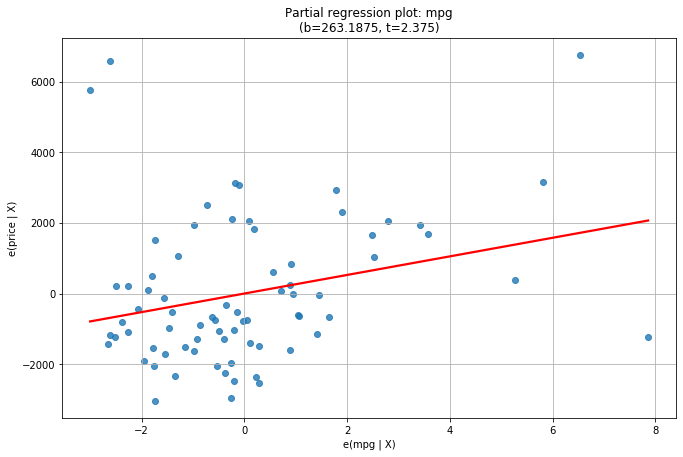

In [25]:
fig, ax = plt.subplots(figsize=(11,7))
partial_regression_plot(model_incomplete, df, 'mpg', annotate_results=True)
plt.show()

A handful of observations, around the corners of the plot, have a high influence on the partial relationship between `price` and `mpg`.  If they are omitted from the regression, the coefficient for `mpg` will be higher.